# TODO:
1) Verify that the data after mosses tokenization is ok

2) Verify what is the value of sent reps (CLS tokens) for mBERT cased

3) Verify that for the uncased I do not need to manually lowercase 

4) Try another implementations for metrics / implement myself / with students

https://github.com/majedelhelou/AL2/blob/e0c796d9145407335fd757e53ce651118bfde21f/code/evaluate.py#L50

5) (ROLL BACK TO python 2 and OLD NUMPY (in new env) AND JUST RUN GOOGLE'S CODE!

In [32]:
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface_lib.embedded import RRuntimeError
import warnings

# The R 'print' function
rprint = robjects.globalenv.find("print")
stats = importr('stats')
grdevices = importr('grDevices')
base = importr('base')
datasets = importr('datasets')

grid.activate()

/home/maksym/.conda/envs/norm/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [33]:
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

In [34]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
os.chdir('..')  # navigate to the root


In [35]:
# plotting
import pandas as pd
import rpy2
import csv

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

In [36]:


# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [37]:
from normal_transformers.util.util_common import pickle_load_from_file

In [38]:
import rpy2.robjects as robjects
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro

In [108]:
from rpy2.robjects.packages import STAP
with open('examples/theme_publication_tartunlp.R', 'r') as f:
    string = f.read()
pub_theme = STAP(string, "pub_theme")

In [40]:
graphics = ro.packages.importr('graphics')
r_utils = ro.packages.importr('utils')
# r_utils.install_packages("ggthemes")
ggthemes = ro.packages.importr('ggthemes')

In [41]:
#r_utils.remove_packages('ggthemes')

In [42]:
model_names_mapping = {
    "xlm-roberta-large": "XLM-R_large",
    "xlm-roberta-base": "XLM-R_base",
    "bert-base-multilingual-cased": "mBERT_cased",
    "bert-base-multilingual-uncased": "mBERT_uncased",
    "distilbert-base-multilingual-cased": "distil_mBERT",
    "xlm-mlm-100-1280": "XLM-MLM_100"
}
    

In [43]:
savedir_base = f"experiments/assets/multilingual"

# Util

In [44]:
def load_sim_scores_csv(model_name_or_dir, data_type, sim_name, sent_rep_type, lang_pairs):
    loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
    sim_scores_dict = {}
    for lang_pair in lang_pairs:
        fn = f"{data_type}_{sim_name}_{sent_rep_type}_{lang_pair}.csv"
        
        with open(f'{loaddir}/{fn}') as csvfile:
            scores = [float(s) for s in list(csv.reader(csvfile))[0]]
            sim_scores_dict[lang_pair] = scores
            
    return sim_scores_dict

In [45]:
def load_sim_scores_into_df(model_name_or_dir, data_type, sim_names, sent_rep_type, lang_pairs, skip_0_layer=False):
    
    # load metrics data
    sim_scores_all_metrics = {} 
    for sim_name in sim_names:
        
        sim_scores_all_metrics[sim_name] = load_sim_scores_csv(
            model_name_or_dir, 
            data_type, sim_name, 
            sent_rep_type, 
            lang_pairs)

    dict_of_sim_scors_dicts = sim_scores_all_metrics
    # craft padnas dataframe from it
    list_of_dfs = []
    for sim_name, sim_scores_dict in dict_of_sim_scors_dicts.items():
        init_layer_index = 0
        if skip_0_layer == True:
            init_layer_index = 1

        sim_scores_dict = {k: v[init_layer_index:] for k, v in sim_scores_dict.items()}
    
        tmp = {str(k).replace("-", "_"): v for k, v in sim_scores_dict.items()}
        sim_scores = tmp
        del tmp

        sim_scores_df = pd.DataFrame.from_dict(sim_scores)
        sim_scores_df["Layer"] = [i for i in range(len(sim_scores_df))]
        sim_scores_df["Similarity"] = [str(sim_name) for i in range(len(sim_scores_df))]

        lang_pair_names = [v for v in sim_scores_df.columns.values if v != "Layer" and v != "Similarity"]
        sim_scores_df = pd.melt(sim_scores_df, id_vars=["Layer", "Similarity"], value_vars=lang_pair_names,
                               var_name='lang_pair', value_name="Score")

        sim_scores_df = sim_scores_df.astype({"Layer": int})
        list_of_dfs.append(sim_scores_df)
    
    final_df = pd.concat(list_of_dfs, ignore_index=True) 
    
    return final_df

    

In [101]:
def ggplot2_plot_lines(df, title):
    gp = ggplot2.ggplot(sim_scores_df)

    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_line(ggplot2.aes_string(color = "lang_pair")) \
    + ggplot2.ylim(0, 1) \
    + ggplot2.facet_grid(ro.Formula('. ~ Similarity')) \
    + pub_theme.theme_Publication() \
    + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF"]) 

    return pp
    #pp.plot()

#  1. Step 1: Influence of metrics

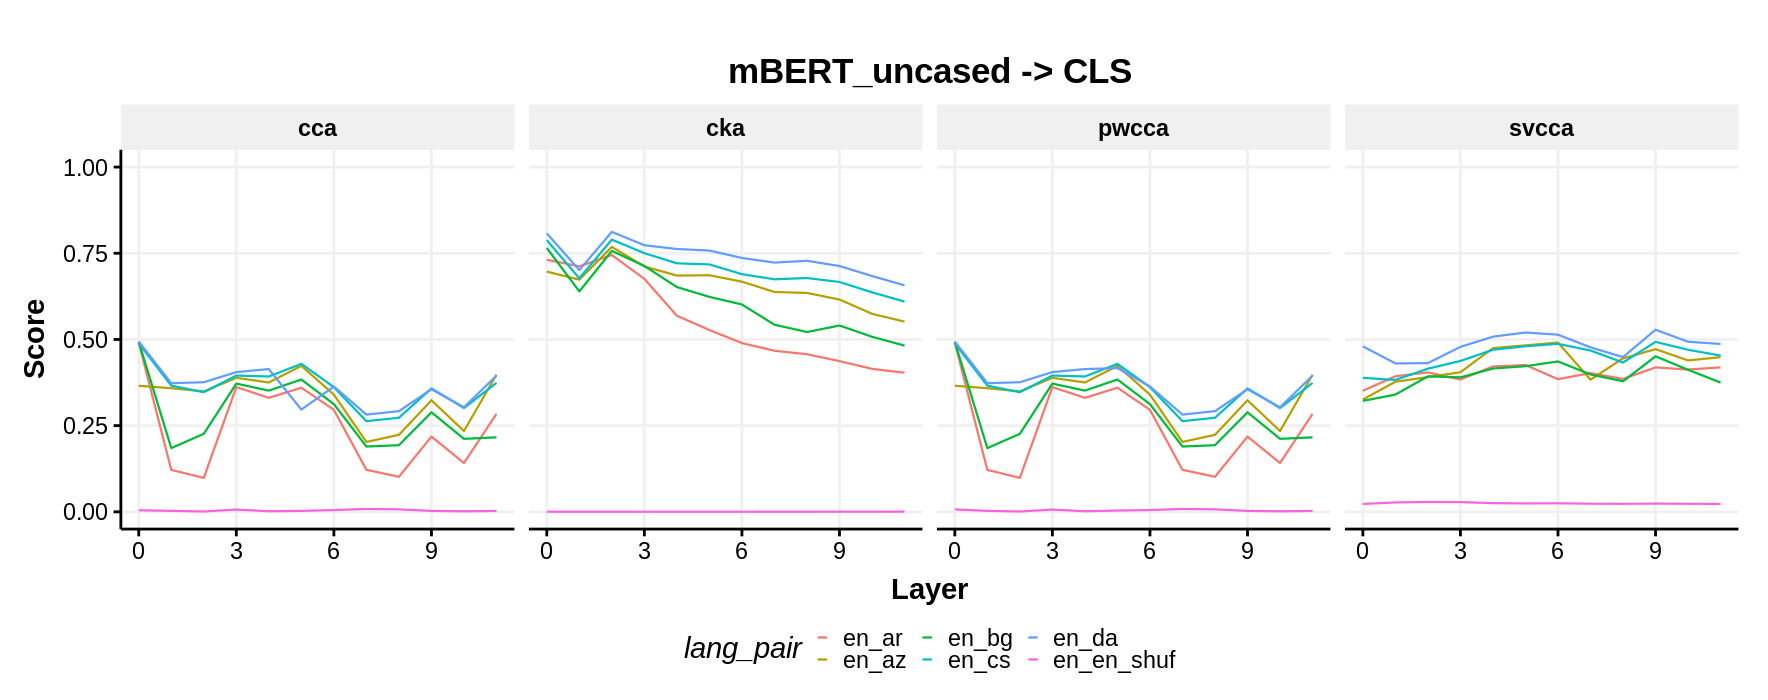

In [109]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "cls"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

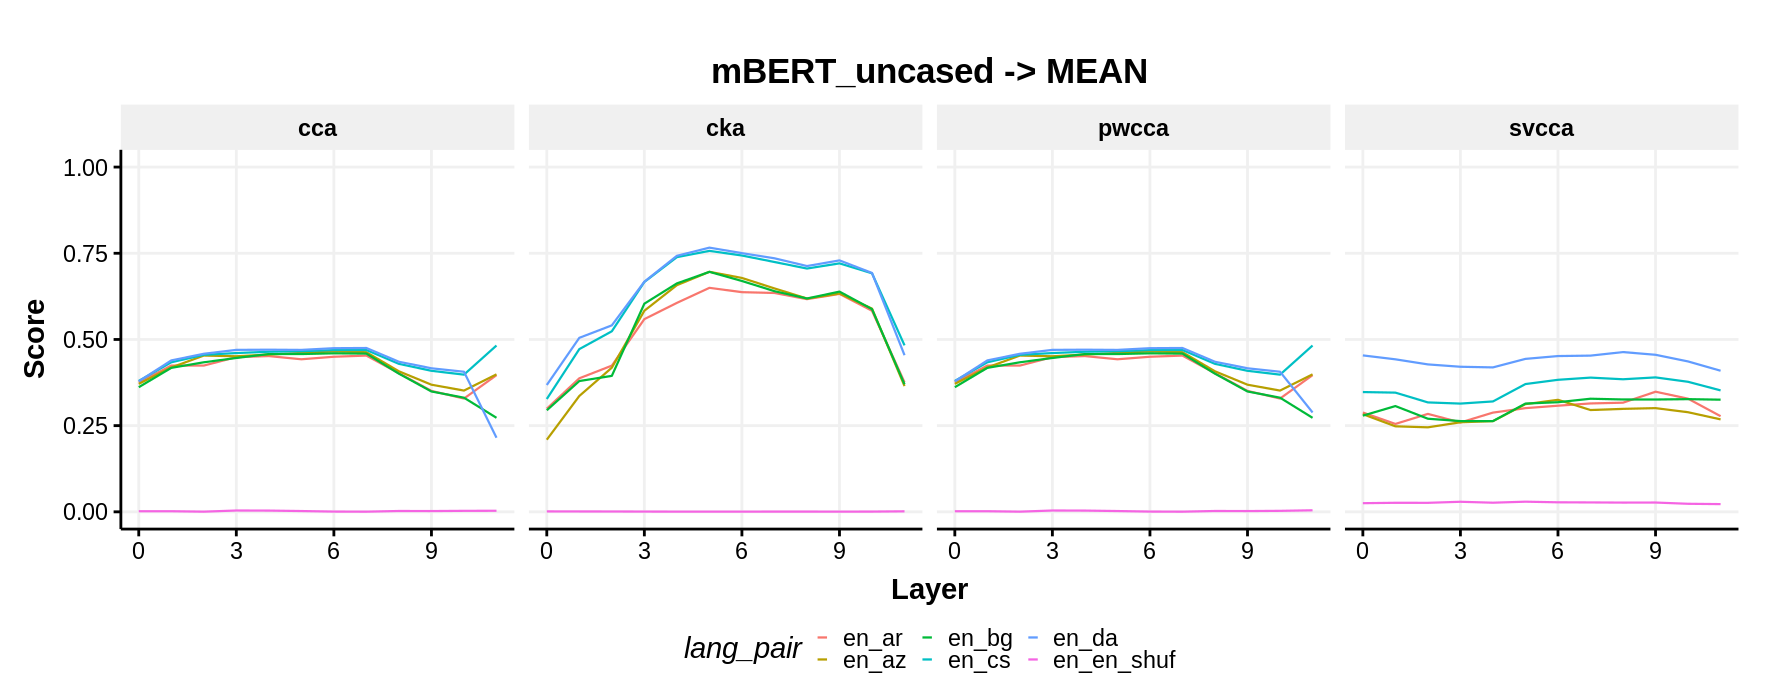

In [110]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-uncased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

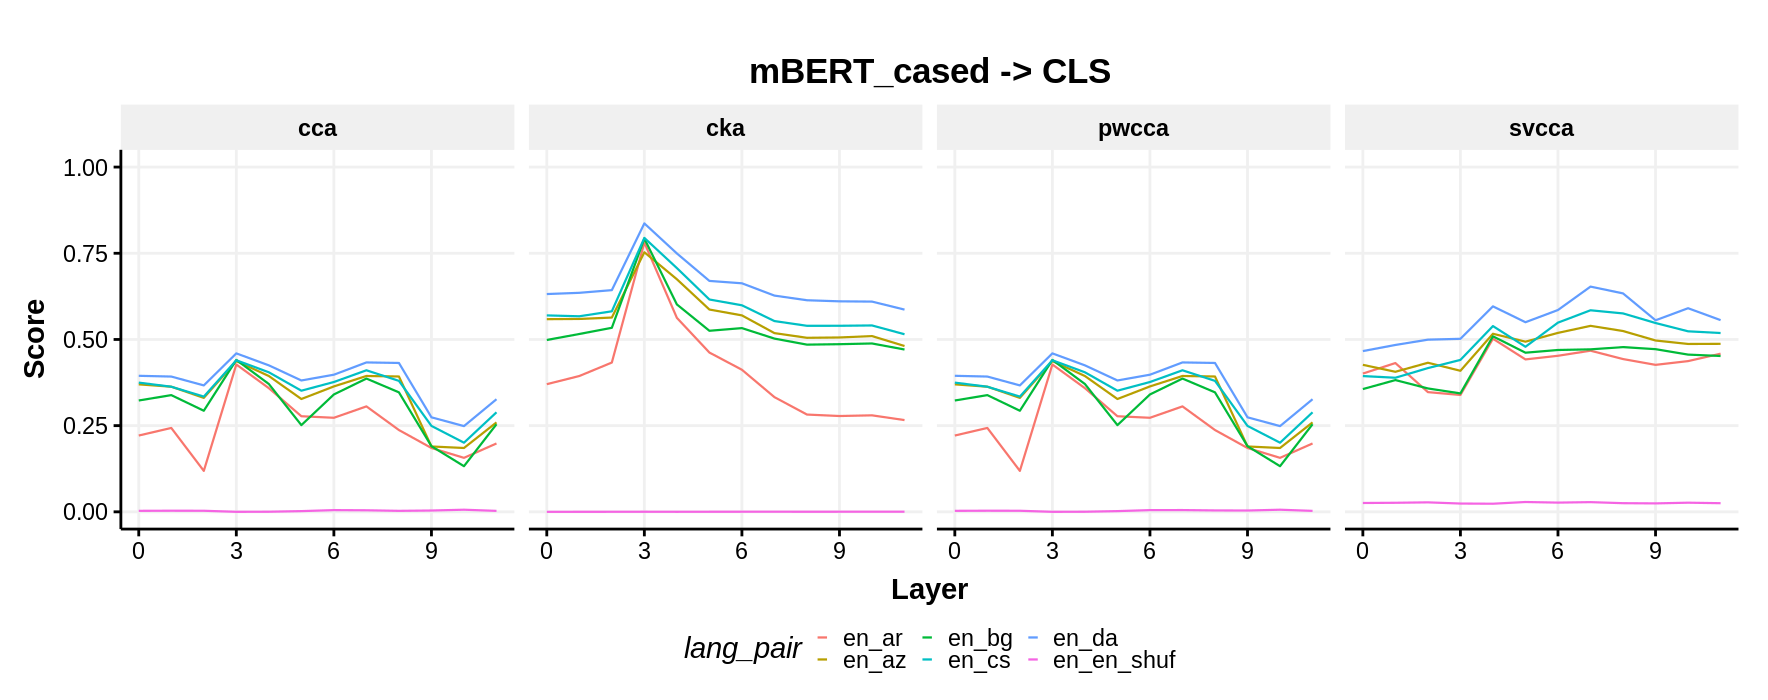

In [112]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-cased"
data_type = "xnli6"
sent_rep_type = "cls"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

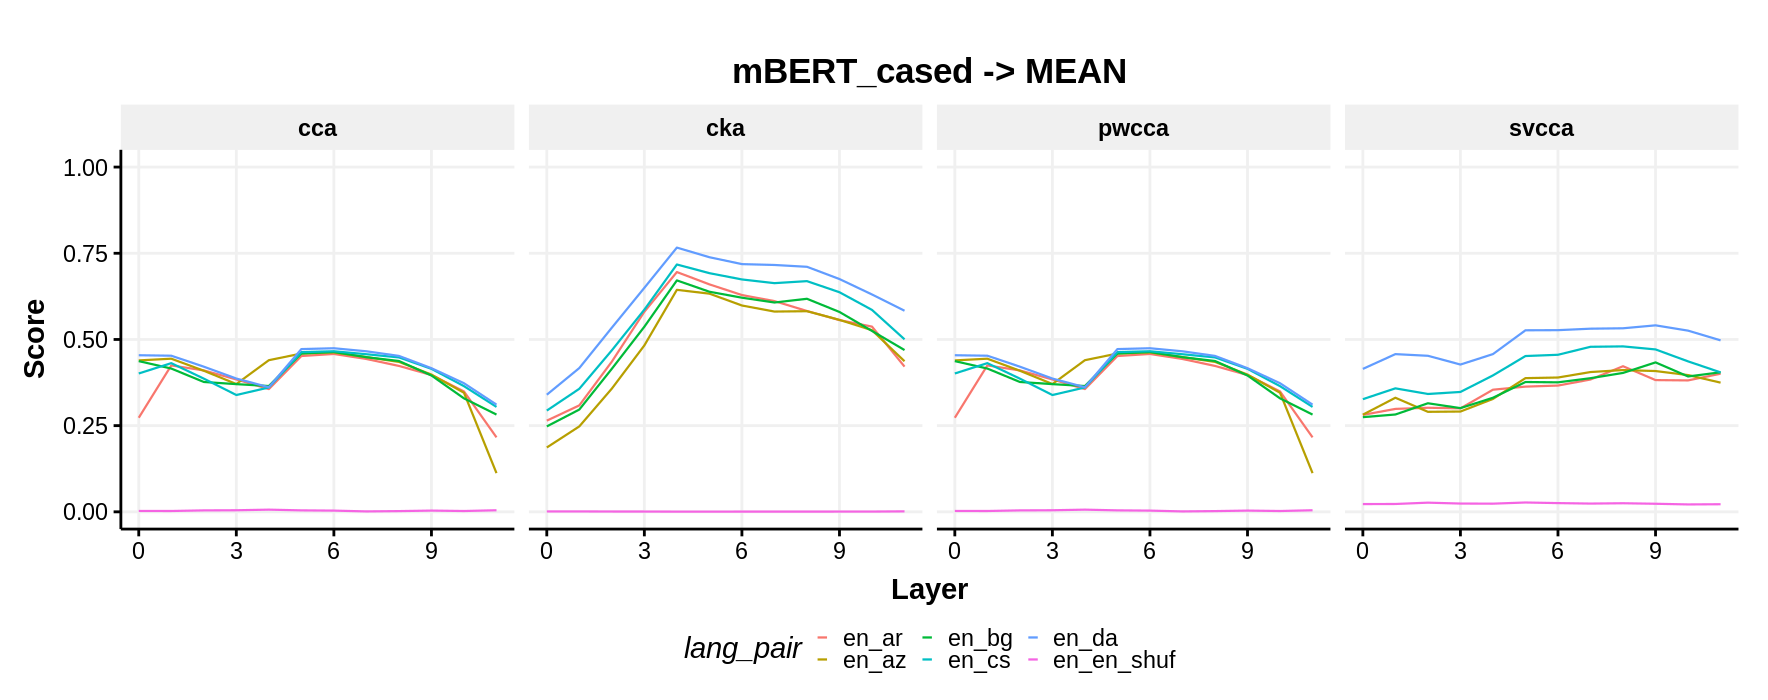

In [113]:
# GLOBALS
model_name_or_dir = "bert-base-multilingual-cased"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

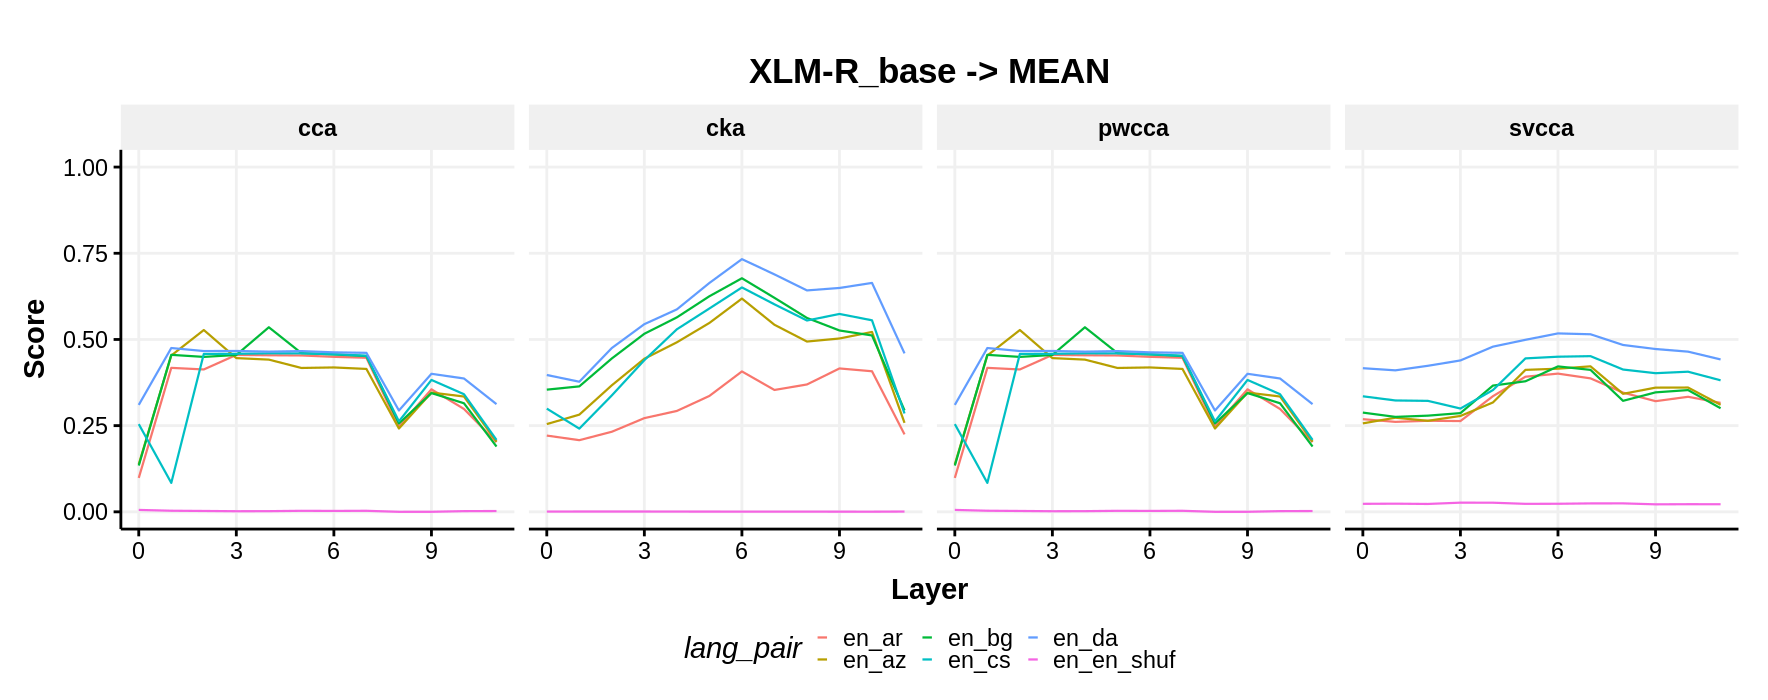

In [114]:
# GLOBALS
model_name_or_dir = "xlm-roberta-base"
data_type = "xnli6"
sent_rep_type = "mean"
sim_names = ["pwcca", "cca", "svcca", "cka"]
lang_pairs = ["en-en_shuf", "en-ar", "en-az", "en-bg", "en-cs", "en-da"]
skip_0_layer = True
# load df

sim_scores_df = load_sim_scores_into_df(
    model_name_or_dir=model_name_or_dir, 
    data_type=data_type, 
    sim_names=sim_names, 
    sent_rep_type=sent_rep_type, 
    lang_pairs=lang_pairs,
    skip_0_layer=skip_0_layer)

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=1768, height=700, res=150) as img:
    title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggplot2_plot_lines(sim_scores_df, title)
    plot = plot
    plot.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

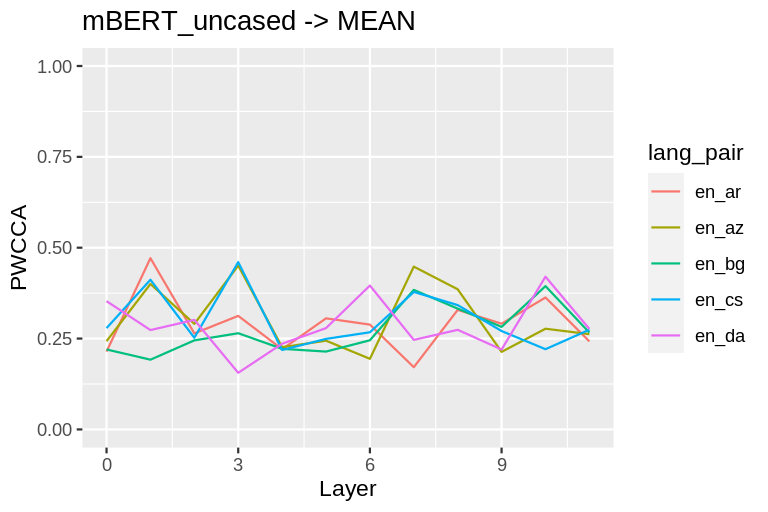

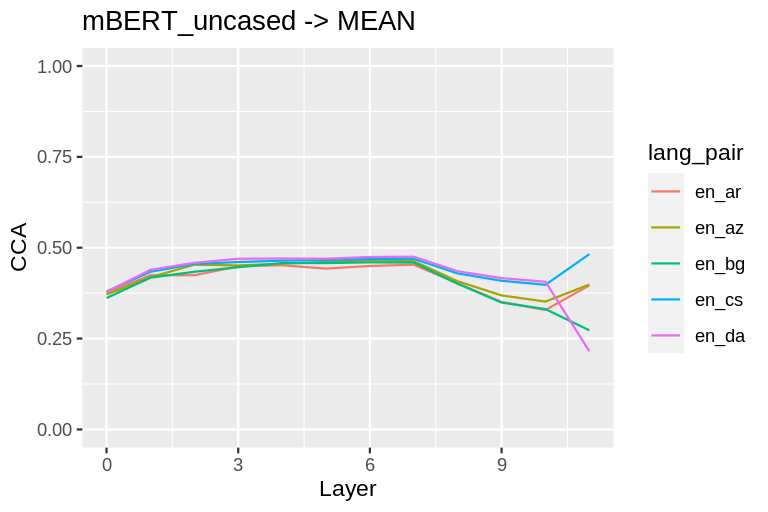

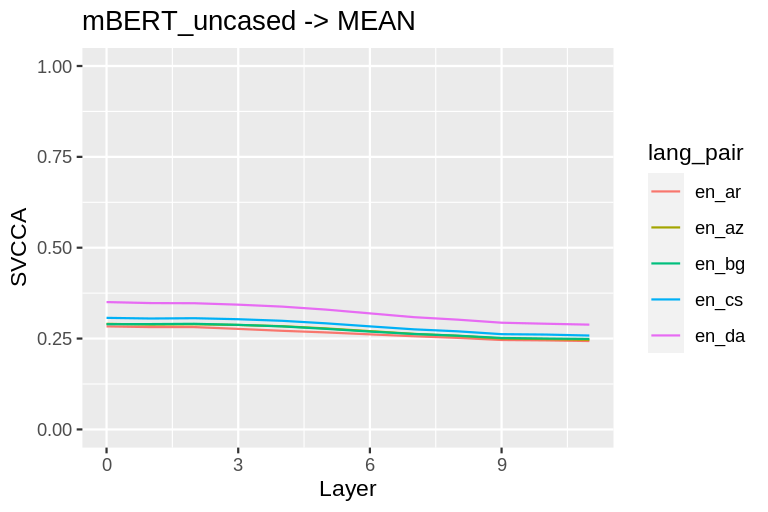

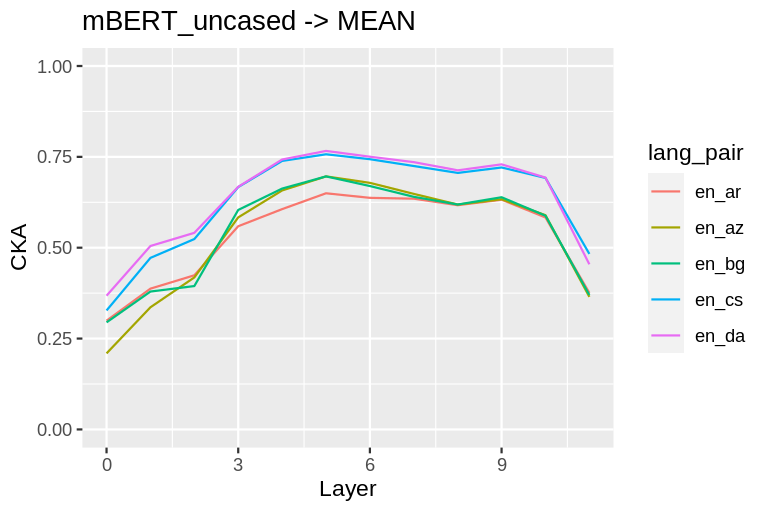

In [22]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["bert-base-multilingual-uncased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

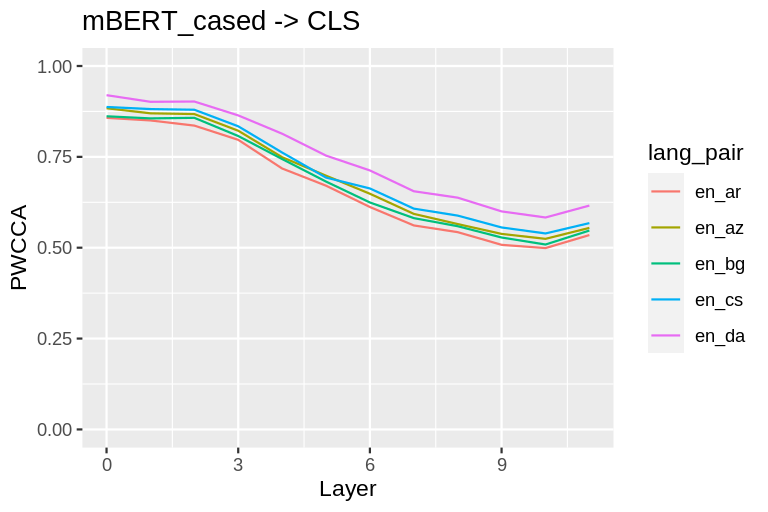

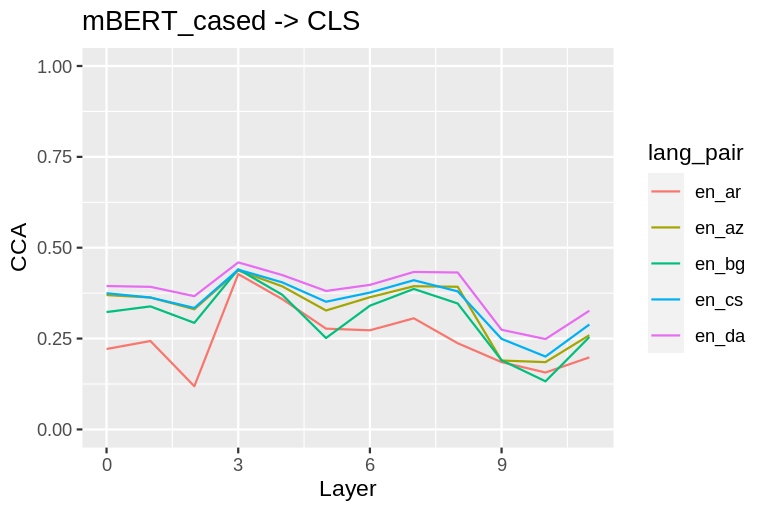

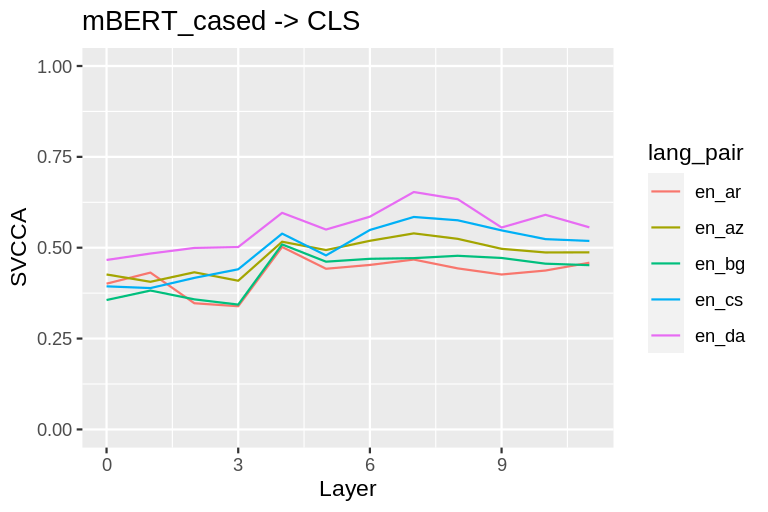

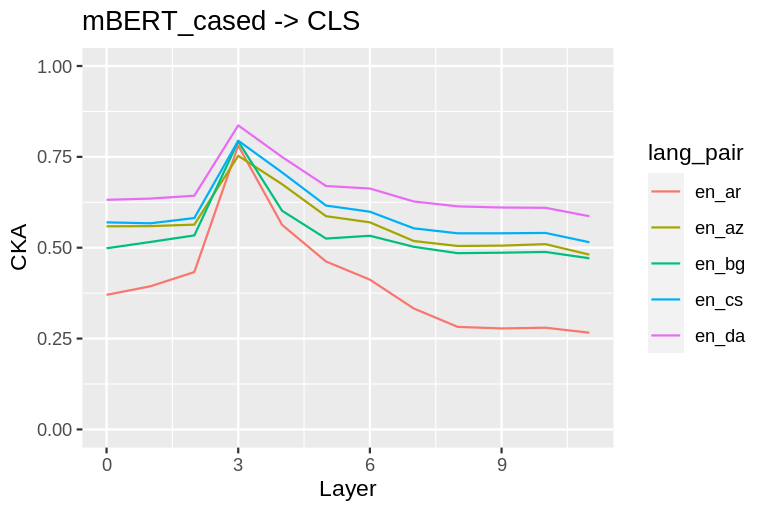

In [23]:
for sent_rep_type in ["cls"]:
    for model_name_or_dir in ["bert-base-multilingual-cased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

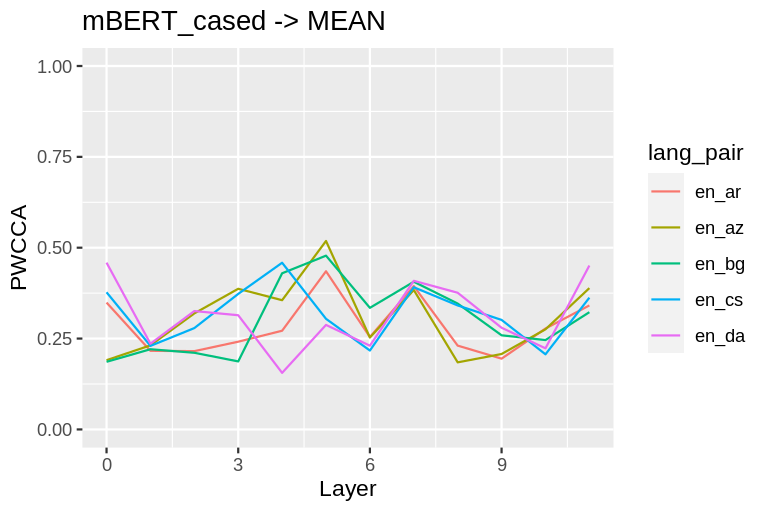

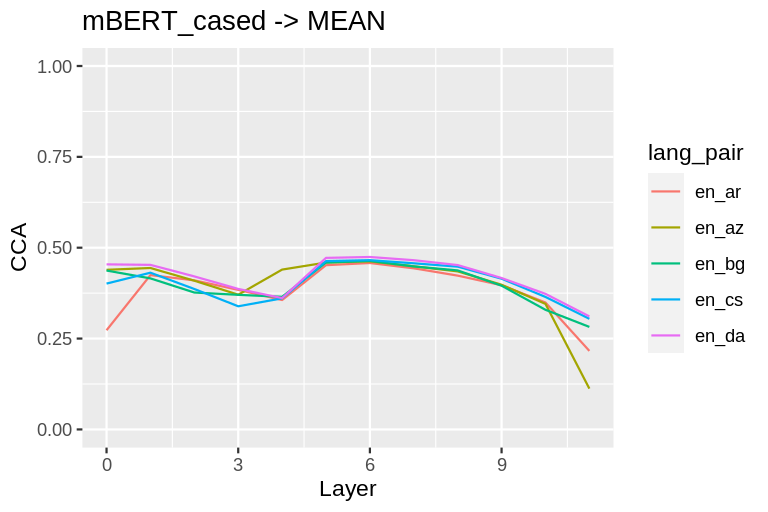

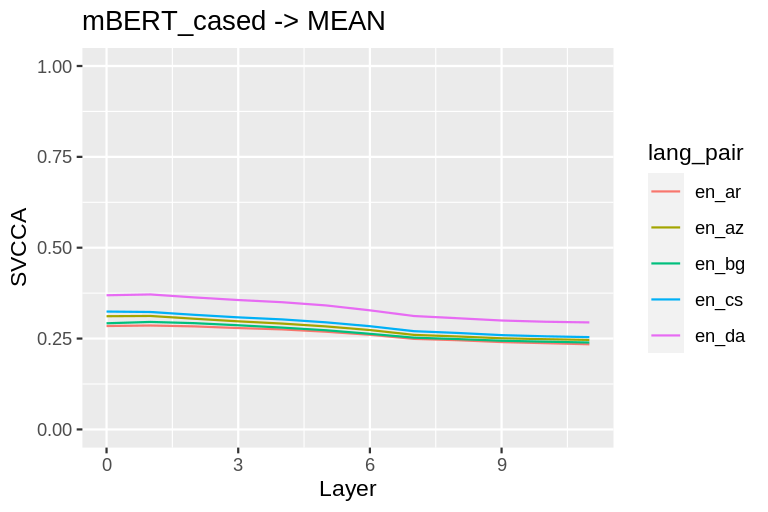

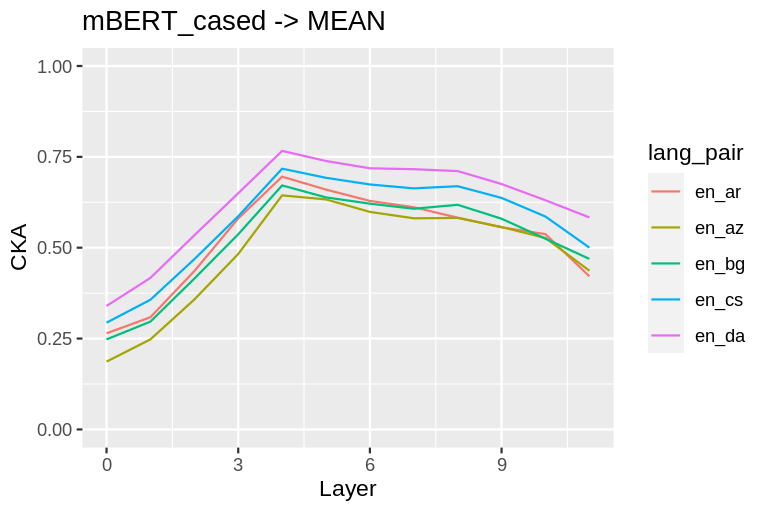

In [24]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["bert-base-multilingual-cased"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            

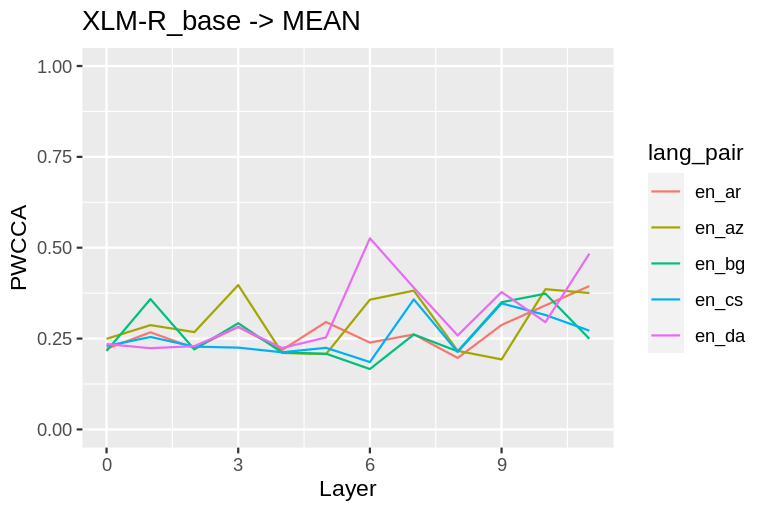

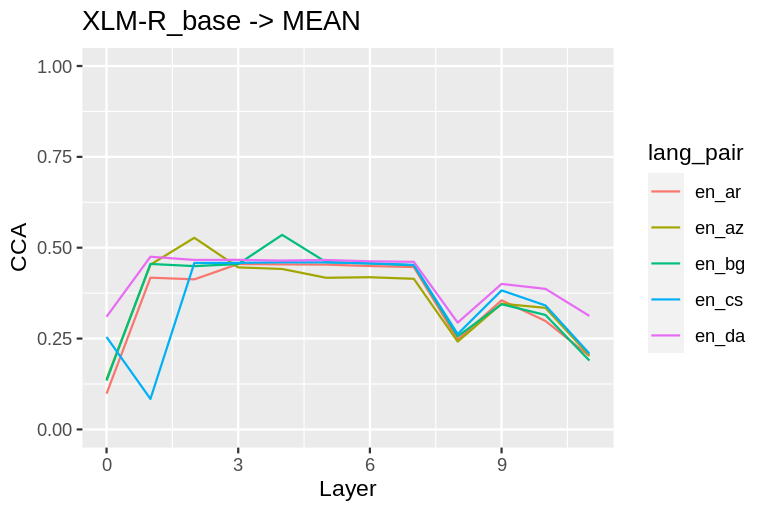

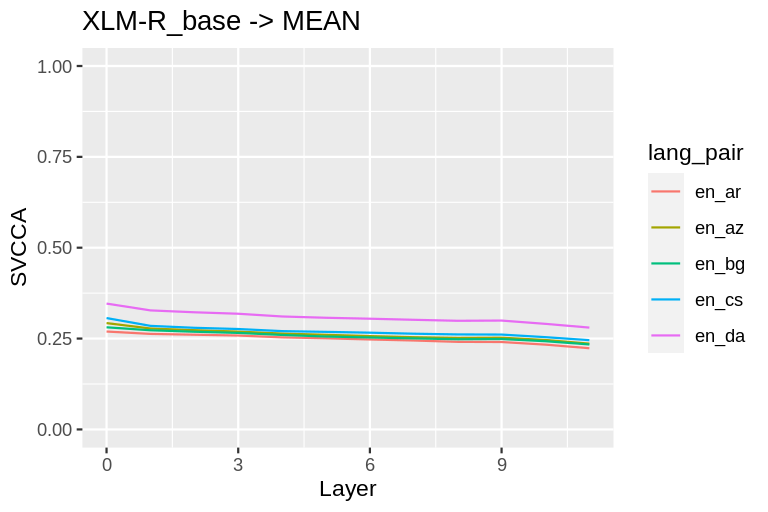

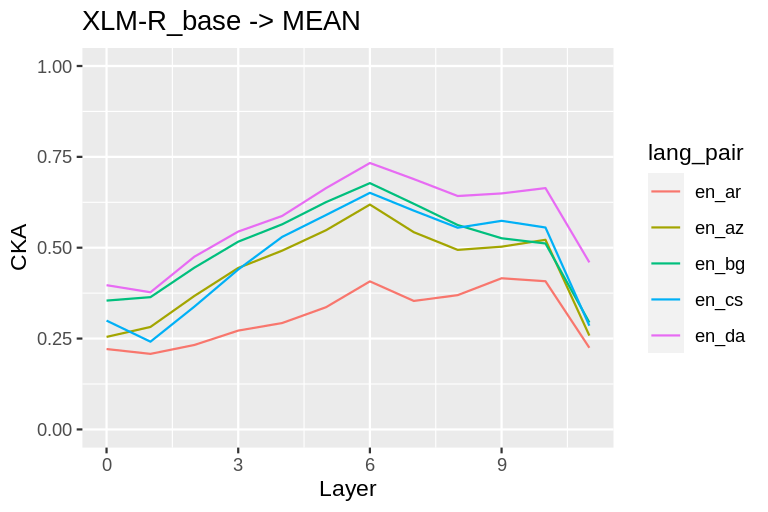

In [25]:
for sent_rep_type in ["mean"]:
    for model_name_or_dir in ["xlm-roberta-base"]:
        loaddir = f"{savedir_base}/{model_name_or_dir}/sim_scores"
        for sim_name in sim_names:
            loadfile_path = f"{loaddir}/xnli6_{sim_name}_{sent_rep_type}.pkl"

            sim_scores = pickle_load_from_file(loadfile_path, verbose=False)

            title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
            ggplot2_plot_lines(sim_scores, title, sim_name.upper())            